# Machine Learning of NASA Asteroid data

## Overview
**Goal:** Find and tune the most optimal model to predict whether an asteroid is hazardous or not.

Our EDA in the previous notebook gave us many insights that we will use in our machine learning pipeline below. We started with 40 columns and have selected 15 features to focus on for this analysis. We will be using both classifiers and ensemble models to predict if an asteroid is hazardous or not, with overall model accuracy being our success metric.

### Load our data

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier

import helper

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [112]:
analysis_df = pd.read_csv("../data/analysis_data.csv")
analysis_df.head()

,Absolute Magnitude,Close Approach Date,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Epoch Osculation,Eccentricity,Perihelion Distance,Aphelion Dist,Perihelion Time,Mean Anomaly,Hazardous,Est Dia in M(avg)
0,21.6,0,22017.003799,62753692.0,534,5,0.025282,2458000.5,0.425549,0.808259,2.005764,2.458162e+06,264.837533,1,205.846088
1,21.3,0,65210.346095,57298148.0,432,3,0.186935,2458000.5,0.351674,0.718200,1.497352,2.457795e+06,173.741112,0,236.342931
2,20.3,1,27326.560182,7622911.5,1910,0,0.043058,2458000.5,0.348248,0.950791,1.966857,2.458120e+06,292.893654,1,374.578302
3,27.4,2,40225.948191,42683616.0,1761,6,0.005512,2458000.5,0.216578,0.983902,1.527904,2.457902e+06,68.741007,0,14.241070
4,21.6,2,35426.991794,61010824.0,1190,1,0.034798,2458000.5,0.210448,0.967687,1.483543,2.457814e+06,135.142133,1,205.846088


## Base classifiers

### "Shotgun Approach": Classification Models
Given the nature of the target data, let's first try seeing the accuracy of classification models.

In [113]:
TARGET = ["Hazardous"]

X, y = analysis_df.drop(columns=TARGET, axis=1), analysis_df[TARGET]

In [114]:
# Train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        train_size=0.7,
                                        test_size=0.3,
                                        random_state=42)

In [115]:
# creating models that we want to test to see which is most optimized
# we will use this to test different X_train variations
cat_models = {
    "KNN": {
        "Estimator": KNeighborsClassifier(),
        },
    "SVM": {
        "Estimator": SVC(),
        },
    "CART": {
        "Estimator": DecisionTreeClassifier(),
        },
    "NB": {
        "Estimator": GaussianNB(),
        },
    "LOGREG": {
        "Estimator": LogisticRegression(),
        }
}

In [116]:
# test performance of different models using X_train
helper.test_models_performance(cat_models, X_train, y_train, isRegressor=False)


[MODEL TYPE: KNN]

>>>> Top Performance: 		0.8293
>>>> Average Performance: 	0.8107
>>>> Spread of Performance: 	0.0104

[MODEL TYPE: SVM]

>>>> Top Performance: 		0.8354
>>>> Average Performance: 	0.8348
>>>> Spread of Performance: 	0.0012

[MODEL TYPE: CART]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9945
>>>> Spread of Performance: 	0.0051

[MODEL TYPE: NB]

>>>> Top Performance: 		0.8476
>>>> Average Performance: 	0.8220
>>>> Spread of Performance: 	0.0157

[MODEL TYPE: LOGREG]

>>>> Top Performance: 		0.8415
>>>> Average Performance: 	0.8338
>>>> Spread of Performance: 	0.0037


The decision tree is probably overfit, as the average performance is 99%, and the top performing tree has a 100% fit. Naive Bayes or Logistic Regression may be the best performing models. Let's use Logistic Regression and try to improve it.

In [117]:
# let's create an instance of that and tune it to have even better accuracy
logreg_model = LogisticRegression()

y_pred = helper.fit_predict(logreg_model, X_train, y_train, X_test, y_test, isRegressor=False)

> ACCURACY: 	84.93%


### Accuracy to beat: 84.93%

## Exhaustive Machine Learning

### Tuning: Standard Scaler

In [118]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [119]:
y_pred = helper.fit_predict(logreg_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	95.02%


Scaling the data increased the accuracy to 95%!
#### Accuracy to beat: 95.02%

### Tuning: MinMax Scaler

In [120]:
# use minmax scaler
# check if that will gain better results
scaler = MinMaxScaler()
X_train_mm_scaled = scaler.fit_transform(X_train)
X_test_mm_scaled = scaler.transform(X_test)

In [121]:
y_pred = helper.fit_predict(logreg_model, X_train_mm_scaled, y_train, X_test_mm_scaled, y_test, isRegressor=False)

> ACCURACY: 	92.54%


Using a MinMax scaler made the accuracy worse. Let's stick to our standard scaled data.

#### Accuracy to beat: 95.02%

### Tuning: GridSearchCV

In [122]:
# let's investigate the expressed signal from each of our features
importances, features = logreg_model.coef_[0], list(X)

feature_importances = [(features[iteration], importances[iteration]) for iteration in range(len(features))]
feature_importances.sort(reverse=True, key=lambda X: X[1])

feature_importances

[('Eccentricity', 0.8945822234224964),
 ('Aphelion Dist', 0.6969495661330356),
 ('Relative Velocity km per hr', 0.5887025912082454),
 ('Mean Anomaly', 0.11972332411952545),
 ('Perihelion Distance', 0.04467061736083125),
 ('Miss Dist.(kilometers)', 0.0270469711715801),
 ('Orbit Determination Date', -0.07232177828083347),
 ('Close Approach Date', -0.29709808147759004),
 ('Epoch Osculation', -0.3167106608492958),
 ('Perihelion Time', -0.5957942862935678),
 ('Est Dia in M(avg)', -1.2607464341376515),
 ('Orbit Uncertainity', -2.5202651722567797),
 ('Absolute Magnitude', -8.452310552720926),
 ('Minimum Orbit Intersection', -13.698405188997702)]

In [123]:
logreg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [124]:
# choose hyperparamters to test in the GridSearchCV
hyperparameters = {
		 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
		 'C': [0.001, 0.01, 0.1, 1, 10, 100],
		 'solver': ["liblinear", "lbfgs", "newton-cg", "sag", "saga"],
		 'max_iter': [100, 200, 500],
		 'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

In [125]:
tuned_model = LogisticRegression(random_state=42)
model_tuner = GridSearchCV(tuned_model, hyperparameters, cv=10)

In [126]:
# commenting this out because it took 16 minutes to run
# model_tuner.fit(X_train_scaled, y_train)

In [127]:
# Most optimal log reg model: LogisticRegression(C=0.001, l1_ratio=0.0, max_iter=500, penalty='none',random_state=42, solver='saga')

# commenting this out because this will cause an error
# if the above cell is also commented out

# optimally_tuned_classifier = model_tuner.best_estimator_

# optimally_tuned_classifier

The code for the grid search was commented out, as it took 16 minutes to run, but the optimal Logistic Regression model it returned was `LogisticRegression(C=0.001, l1_ratio=0.0, max_iter=500, penalty='none',random_state=42, solver='saga')`

From the hyperparameters fed into the GridSearchCV, we see the most optimal hyperparameters for our LogisticRegression.

In [128]:
# commenting this out because this will cause an error
# if the above cell is also commented out

# Get accuracy of the most optimal classifier
# y_pred = optimally_tuned_classifier.predict(X_test_scaled)

# helper.print_accuracy(y_test, y_pred, isRegressor=False)

Our most optimally tuned classifier has the same accuracy as our previous model.

#### Accuracy to beat: 95.02%

### Accuracy Evaluation

#### Confusion Matrix & Classification Report

In [129]:
# creating an instance of the most iptimally tuned model
logreg_model = LogisticRegression(C=0.001, l1_ratio=0.0, max_iter=500, penalty='none',random_state=42, solver='saga')

y_pred = helper.fit_predict(logreg_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	95.02%


confusion matrix:
 [[1158   36]
 [  34  179]]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1194
           1       0.83      0.84      0.84       213

    accuracy                           0.95      1407
   macro avg       0.90      0.91      0.90      1407
weighted avg       0.95      0.95      0.95      1407



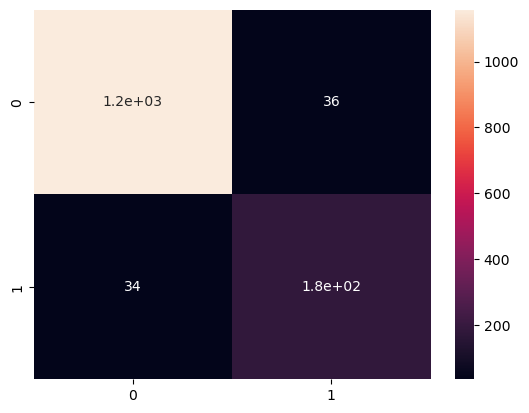

In [130]:
# check confusion matrix
helper.print_confusion_matrix_details(y_test, y_pred)

In [131]:
analysis_df["Hazardous"].value_counts()

Hazardous
0    3932
1     755
Name: count, dtype: int64

### Tuning: Class Weights
The confusion matrix and classification report show that the accuracy of 0 and 1 is very different, probably because of imbalanced data. Let's try to change the class weights in the model to see if the accuracy improves.

In [132]:
# change the class weights to try to improve accuracy
logreg_model.class_weight = {0: 0.3, 1: 0.7}
y_pred = helper.fit_predict(logreg_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	94.39%


confusion matrix:
 [[1133   61]
 [  18  195]]

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1194
           1       0.76      0.92      0.83       213

    accuracy                           0.94      1407
   macro avg       0.87      0.93      0.90      1407
weighted avg       0.95      0.94      0.95      1407



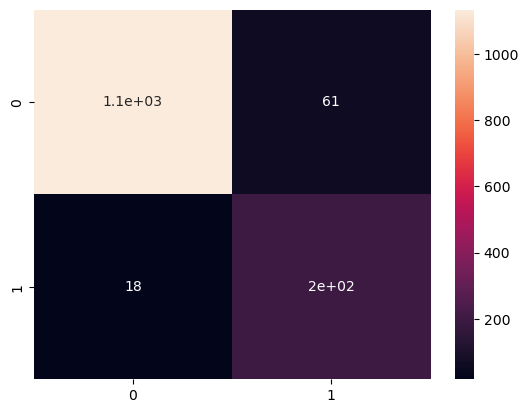

In [133]:
helper.print_confusion_matrix_details(y_test, y_pred)

In [134]:
helper.print_accuracy(y_test, y_pred, False)

> ACCURACY: 	94.39%


After changing the class weights to weigh hazardous asteroid data more, recall of hazardous asteroids increased, but precision went down. The overall f1 for both classes stayed the same. Our previous model without the class weights performed better, so that is still the accuracy to beat.

#### Accuracy to beat: 95.02%

### Tuning: Threshold
Calculating the precision-recall curve might help us find the threshold that best balances our imbalanced classes.

In [135]:
# change the class weights back to balanced like before
logreg_model.class_weight = None

In [136]:
# predict probabilities on the test set
y_pred_probs = logreg_model.predict_proba(X_test_scaled)[:, 1]

# calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

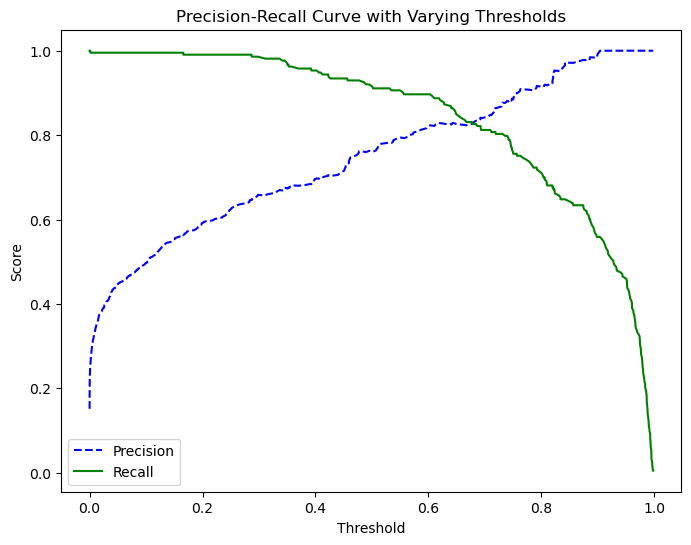

In [137]:
# plot the Precision-Recall curve
plt.figure(figsize=(8, 6))

plt.plot(thresholds, precision[:-1], 'b--', label="Precision")
plt.plot(thresholds, recall[:-1], 'g-', label="Recall")

plt.title("Precision-Recall Curve with Varying Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")

plt.show()

In [138]:
# find the threshold that balances precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.6031599225636174


confusion matrix:
 [[1153   41]
 [  22  191]]

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1194
           1       0.82      0.90      0.86       213

    accuracy                           0.96      1407
   macro avg       0.90      0.93      0.92      1407
weighted avg       0.96      0.96      0.96      1407



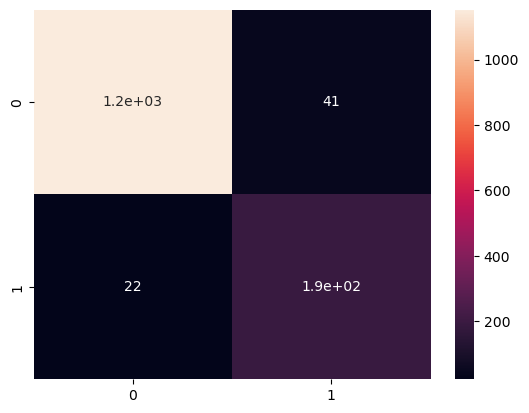

In [139]:
# use the optimal threshold for classification
y_pred_optimal = (y_pred_probs >= optimal_threshold).astype(int)

# check the confusion matrix and classification report of this 
helper.print_confusion_matrix_details(y_test, y_pred_optimal)

In [140]:
helper.print_accuracy(y_test, y_pred, False)

> ACCURACY: 	94.39%


Although the overall accuracy went down, the precision and recall of hazardous increased. However, our original model still wins!
#### Accuracy to beat: 95.02%

### Metrics: ROC-AUC Curve

In [141]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)

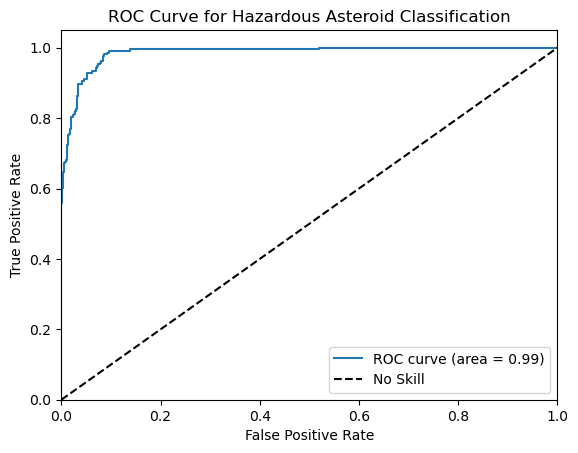

In [142]:
# plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hazardous Asteroid Classification')
plt.legend()
plt.show()

The area under the curve (AUC) of our ROC represents the model's overall performance, which indicates this model is performing very well. The closer an AUC is to 1, the better it is at predicting between the correct classes, and as our AUC is 0.99, it seems our model performs quite well.

## Ensemble Models
Let's explore how different ensemble models perform on this data. Ensemble models like Random Forests or Gradient Boosting (ex. XGBoost) often perform better on imbalanced data and can improve overall performance on minority classes.

### "Shotgun Approach:" Ensemble Models

In [143]:
# creating models that we want to test to see which is most optimized
# we will use this to test different X_train variations
ensemble_models = {
    "RandomForest": {
        "Estimator": RandomForestClassifier(),
        },
    "XGB": {
        "Estimator": XGBClassifier(),
        },
    "ADABoost": {
        "Estimator": AdaBoostClassifier(),
        }
}

In [144]:
# test performance of different models using X_train
helper.test_models_performance(ensemble_models, X_train, y_train, isRegressor=False)


[MODEL TYPE: RandomForest]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9960
>>>> Spread of Performance: 	0.0045

[MODEL TYPE: XGB]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9966
>>>> Spread of Performance: 	0.0048

[MODEL TYPE: ADABoost]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9970
>>>> Spread of Performance: 	0.0039


In [145]:
# test performance of different models using X_train
helper.test_models_performance(ensemble_models, X_train_scaled, y_train, isRegressor=False)


[MODEL TYPE: RandomForest]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9951
>>>> Spread of Performance: 	0.0050

[MODEL TYPE: XGB]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9966
>>>> Spread of Performance: 	0.0048

[MODEL TYPE: ADABoost]

>>>> Top Performance: 		1.0000
>>>> Average Performance: 	0.9970
>>>> Spread of Performance: 	0.0039


### Accuracy Evaluation
Both ensemble models perform a little too well at around 99 - 100% accuracy. Look at their confusion matrices and classification reports to understand better.

In [146]:
# Let's instantiate a Random Forest model
rf_model = RandomForestClassifier()
y_pred = helper.fit_predict(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, isRegressor=False)

> ACCURACY: 	99.50%


confusion matrix:
 [[1190    4]
 [   3  210]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1194
           1       0.98      0.99      0.98       213

    accuracy                           1.00      1407
   macro avg       0.99      0.99      0.99      1407
weighted avg       1.00      1.00      1.00      1407



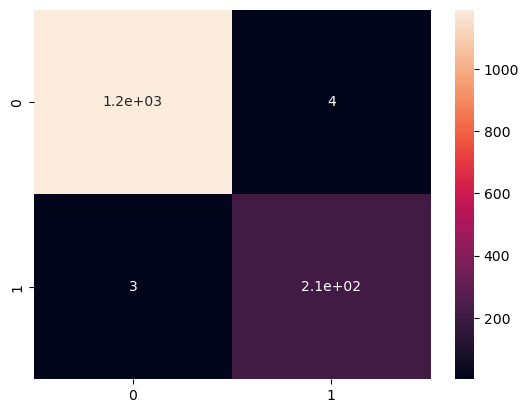

In [147]:
helper.print_confusion_matrix_details(y_test, y_pred)

In [148]:
helper.print_accuracy(y_test, y_pred, False)

> ACCURACY: 	99.50%


The Random Forest model outperforms our original Logistic Regression model with its higher accuracy (99.50% vs. 95.02%) and stronger precision, recall, and F1-scores for both classes, indicating fewer misclassifications overall. This makes the Random Forest model our winning model for this dataset!

#### Accuracy to beat: 99.50%

### Feature Importance

In [149]:
# let's see the importance of our features
# on our most successful logistic regression model

importances, features = rf_model.feature_importances_, X.columns

feature_importances = [(features[iteration], importances[iteration]) for iteration in range(len(features))]
feature_importances.sort(reverse=True, key=lambda X: X[1])

feature_importances

[('Minimum Orbit Intersection', 0.4726095042184679),
 ('Absolute Magnitude', 0.17512913759676338),
 ('Est Dia in M(avg)', 0.13701567438700274),
 ('Orbit Uncertainity', 0.04445867166953699),
 ('Perihelion Distance', 0.03958702372203782),
 ('Orbit Determination Date', 0.03951791062267746),
 ('Miss Dist.(kilometers)', 0.02365602244858153),
 ('Relative Velocity km per hr', 0.0147785977823793),
 ('Eccentricity', 0.013077745699333784),
 ('Aphelion Dist', 0.01284736960762772),
 ('Mean Anomaly', 0.010519198462733918),
 ('Perihelion Time', 0.007701451064752),
 ('Close Approach Date', 0.007410038658280668),
 ('Epoch Osculation', 0.0016916540598249572)]

In [150]:
# split out feature_importances for our bar plot

x_features = [feature_importance[0] for feature_importance in feature_importances]
y_importances = [feature_importance[1] for feature_importance in feature_importances]

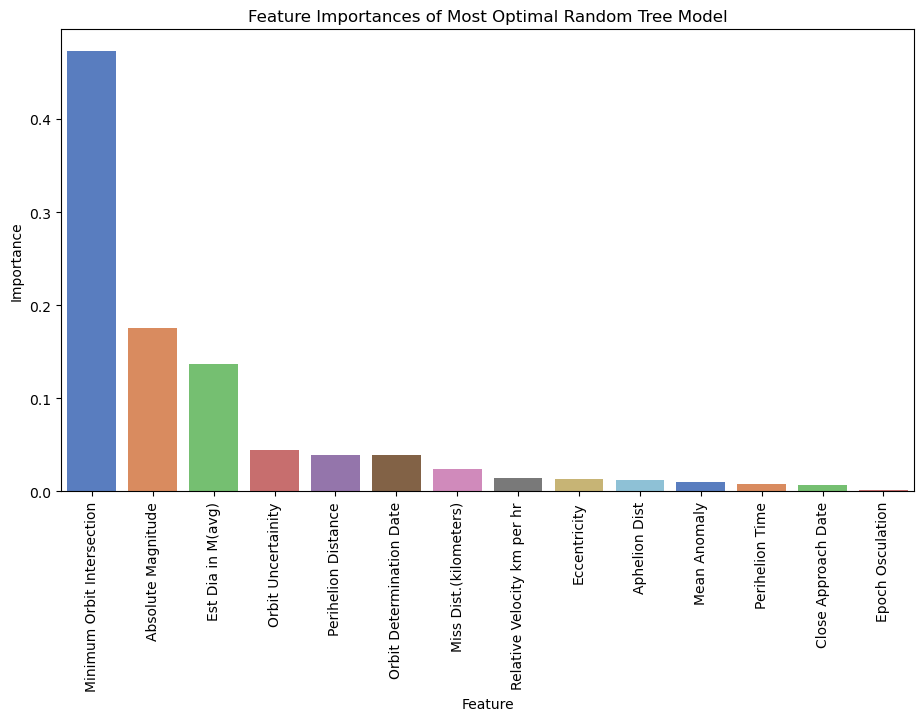

In [151]:
# Presentation Visual
# Plot the importance of each feature in our winning Random Forest model
plt.figure(figsize=(11, 6))

sns.barplot(x=x_features, y=y_importances, palette="muted")
plt.title("Feature Importances of Most Optimal Random Tree Model")
plt.xlabel("Feature")
plt.xticks(rotation=90)

plt.ylabel("Importance")
plt.show()

From this graph, we can see that minimum orbit intersection is the most important feature to predict whether an asteroid is hazardous or not. Epoch osculation is the least important feature to predict an asteroid's hazaard type.

### Metrics: ROC-AUC Curve

In [152]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)

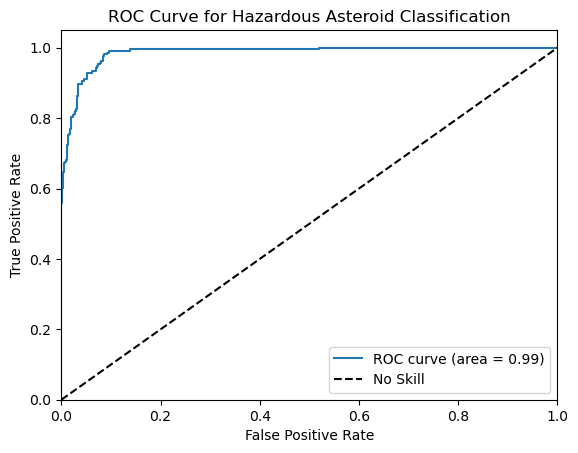

In [153]:
# plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hazardous Asteroid Classification')
plt.legend()
plt.show()

The area under the curve (AUC) of our ROC represents the model's overall performance, which indicates this model is performing very well. The closer an AUC is to 1, the better it is at predicting between the correct classes, and as our AUC is 0.99, it seems our model performs quite well.

# Summary

The Random Forest was the model that performed the best with our asteroid data and was able to predict with the highest accuracy (99.50%) whether an asteroid was hazardous or not, based on the selected features.

Moving forward, we can implement some methods that could improve this model further:
- More feature selection: We included 15 features in this analysis. Dropping or combining some features that affect our accuracy score could be useful in the future.
- Hyperparameter tuning: Because our accuracy score was already quite high with the Random Forest model, we didn't do any hyperparameter tuning. However, in the future, we could perform a selective GridSearchCV with this model to understand which hyperparameters would be even better to put into our model.